In [38]:
# %% [markdown]
# # Prepare Data

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load new dataset
file_path = "Returns_Data_Cleaned.csv"  # Updated file path
df = pd.read_csv(file_path)

# Rename the first column (date column) properly
df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Filter for only the required industries
selected_industries = ["Food", "Smoke", "MedEq", "Drugs", "Telcm"]
df = df[["Dates"] + selected_industries]

# Convert Date column to DateTime format
df = df[df["Dates"].astype(str).str.match(r"^\d{6}$")]  # Keep only YYYYMM format
df["Dates"] = pd.to_datetime(df["Dates"], format="%Y%m")

# Filter data for the required date range
df_filtered = df[(df["Dates"] >= "2019-12-01") & (df["Dates"] <= "2024-11-01")]

# Convert returns from percentage format to decimal (divide by 100)
df_filtered.iloc[:, 1:] = df_filtered.iloc[:, 1:].div(100)

# Set Date as index
df_filtered.set_index("Dates", inplace=True)

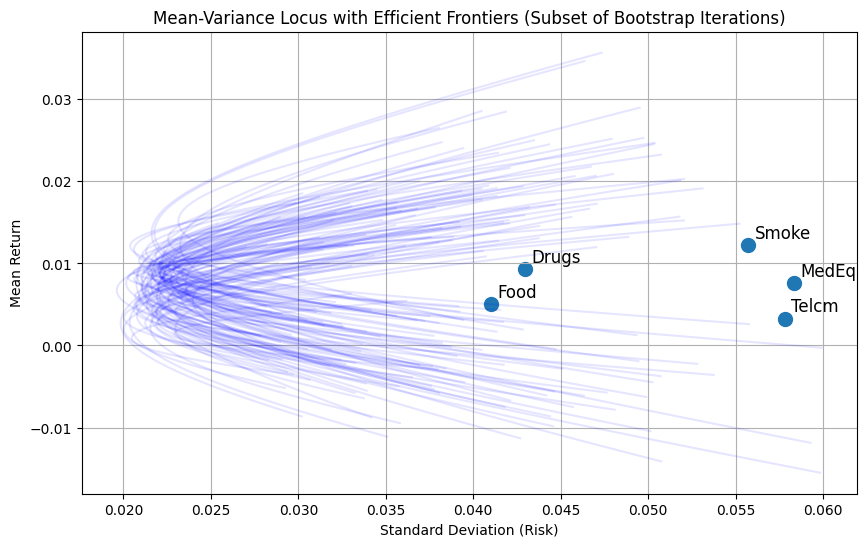

In [39]:
# Define parameters
n_bootstrap = 1000  # Total bootstrap iterations
n_samples = 100  # Limit to 100 iterations for efficiency
n_months = 60  # Number of months per bootstrap sample
selected_industries = ["Food", "Smoke", "MedEq", "Drugs", "Telcm"]
num_industries = len(selected_industries)

# Perform bootstrap resampling
bootstrap_samples = {
    industry: np.array([
        df_filtered.sample(n=n_months, replace=True)[industry].values
        for _ in range(n_bootstrap)
    ])
    for industry in selected_industries
}

# Compute mean and standard deviation for each bootstrap iteration
bootstrap_means = pd.DataFrame({industry: np.mean(bootstrap_samples[industry], axis=1) for industry in selected_industries})
bootstrap_stds = pd.DataFrame({industry: np.std(bootstrap_samples[industry], axis=1) for industry in selected_industries})

# Compute expected return and risk (mean of bootstrap means and stds)
expected_returns = bootstrap_means.mean(axis=0)
expected_risks = bootstrap_stds.mean(axis=0)

# Select a subset of bootstrap iterations
subset_indices = np.linspace(0, n_bootstrap - 1, n_samples, dtype=int)
subset_means = bootstrap_means.iloc[subset_indices]
subset_stds = bootstrap_stds.iloc[subset_indices]


# Store efficient frontiers for the subset
efficient_frontiers = []

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds for weights (between 0 and 1 for long-only portfolios)
    bounds = [(-10, 10)] * num_industries
    
    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers.append((frontier_returns, frontier_risks))

# Plot mean-variance locus and efficient frontiers
plt.figure(figsize=(10, 6))
plt.scatter(expected_risks, expected_returns, marker='o', s=100, label="Industries")

# Plot efficient frontiers for each bootstrap subset iteration
for frontier_returns, frontier_risks in efficient_frontiers:
    plt.plot(frontier_risks, frontier_returns, alpha=0.1, color='blue')

# Annotate each industry
for industry in selected_industries:
    plt.annotate(industry, (expected_risks[industry], expected_returns[industry]), fontsize=12, xytext=(5,5), textcoords='offset points')

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers (Subset of Bootstrap Iterations)")
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


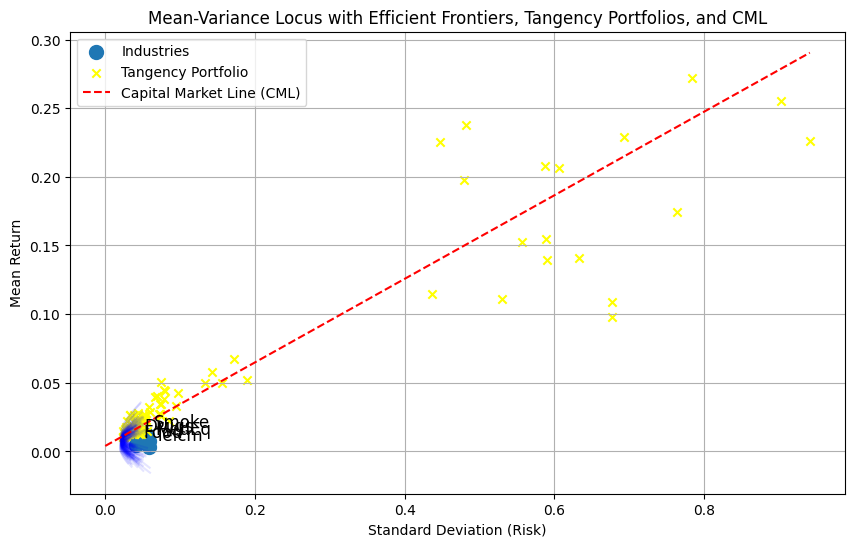

In [40]:

# Store efficient frontiers and tangency portfolios
rf=0.004
efficient_frontiers = []
tangency_points = []

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds for weights (between 0 and 1 for long-only portfolios)
    bounds = [(-10, 10)] * num_industries
    
    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers.append((frontier_returns, frontier_risks))

    # Compute Tangency Portfolio (Max Sharpe Ratio)
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - rf) / portfolio_volatility  # Negative Sharpe to minimize

    result = minimize(negative_sharpe_ratio, initial_guess, bounds=bounds, constraints=constraints)
    
    if result.success:
        tangency_return = np.sum(result.x * mean_returns)
        tangency_risk = np.sqrt(result.x.T @ cov_matrix @ result.x)
        tangency_points.append((tangency_risk, tangency_return))
    else:
        tangency_points.append((np.nan, np.nan))  # Handle failures

# Convert tangency points to arrays
tangency_points = np.array(tangency_points)

# Compute CML endpoints (extend the line beyond tangency portfolio)
cml_risks = np.linspace(0, np.nanmax(tangency_points[:, 0]), 100)
cml_returns = rf + (tangency_points[:, 1].mean() - rf) / tangency_points[:, 0].mean() * cml_risks

# Plot mean-variance locus, efficient frontiers, and tangency portfolios
plt.figure(figsize=(10, 6))
plt.scatter(expected_risks, expected_returns, marker='o', s=100, label="Industries")

# Plot efficient frontiers for each bootstrap subset iteration
for frontier_returns, frontier_risks in efficient_frontiers:
    plt.plot(frontier_risks, frontier_returns, alpha=0.1, color='blue')

# Plot Tangency Portfolios
plt.scatter(tangency_points[:, 0], tangency_points[:, 1], marker='x', color='yellow', label="Tangency Portfolio")

# Plot CML
plt.plot(cml_risks, cml_returns, color='red', linestyle="--", label="Capital Market Line (CML)")

# Annotate each industry
for industry in selected_industries:
    plt.annotate(industry, (expected_risks[industry], expected_returns[industry]), fontsize=12, xytext=(5,5), textcoords='offset points')

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers, Tangency Portfolios, and CML")
plt.legend()
plt.grid(True)
plt.show()

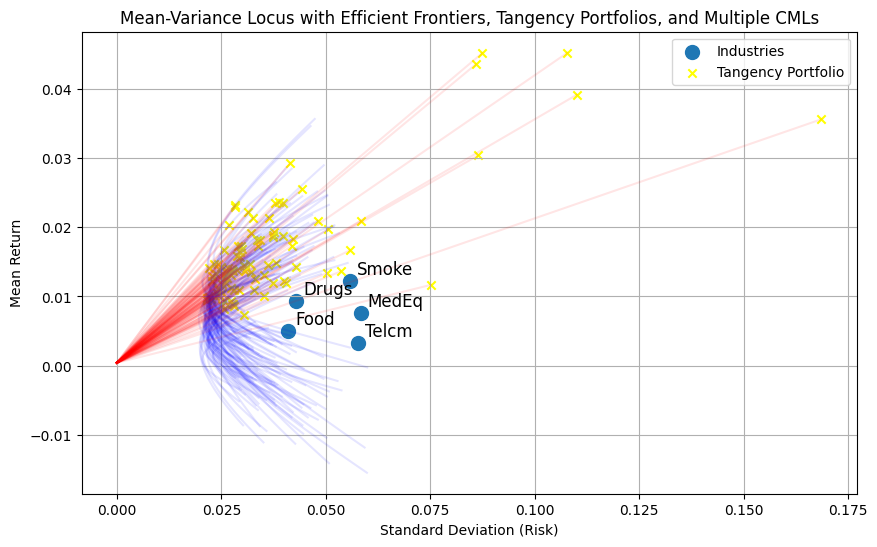

In [41]:
# Store efficient frontiers and tangency portfolios
rf=0.0004
efficient_frontiers = []
tangency_points = []

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds for weights (between 0 and 1 for long-only portfolios)
    bounds = [(-10, 10)] * num_industries
    
    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers.append((frontier_returns, frontier_risks))

    # Compute Tangency Portfolio (Max Sharpe Ratio)
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - rf) / portfolio_volatility  # Negative Sharpe to minimize

    result = minimize(negative_sharpe_ratio, initial_guess, bounds=bounds, constraints=constraints)
    
    if result.success:
        tangency_return = np.sum(result.x * mean_returns)
        tangency_risk = np.sqrt(result.x.T @ cov_matrix @ result.x)
        tangency_points.append((tangency_risk, tangency_return))
    else:
        tangency_points.append((np.nan, np.nan))  # Handle failures

# Convert tangency points to arrays
tangency_points = np.array(tangency_points)

# Plot mean-variance locus, efficient frontiers, tangency portfolios, and individual CMLs
plt.figure(figsize=(10, 6))
plt.scatter(expected_risks, expected_returns, marker='o', s=100, label="Industries")

# Plot efficient frontiers for each bootstrap subset iteration
for frontier_returns, frontier_risks in efficient_frontiers:
    plt.plot(frontier_risks, frontier_returns, alpha=0.1, color='blue')

# Plot CMLs for each bootstrap iteration
for i in range(n_samples):
    if not np.isnan(tangency_points[i, 0]):  # Ensure valid tangency portfolio
        cml_risks = np.linspace(0, tangency_points[i, 0], 50)
        cml_returns = rf + (tangency_points[i, 1] - rf) / tangency_points[i, 0] * cml_risks
        plt.plot(cml_risks, cml_returns, color='red', alpha=0.1)

# Plot Tangency Portfolios
plt.scatter(tangency_points[:, 0], tangency_points[:, 1], marker='x', color='yellow', label="Tangency Portfolio")

# Annotate each industry
for industry in selected_industries:
    plt.annotate(industry, (expected_risks[industry], expected_returns[industry]), fontsize=12, xytext=(5,5), textcoords='offset points')

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers, Tangency Portfolios, and Multiple CMLs")
plt.legend()
plt.grid(True)
plt.show()

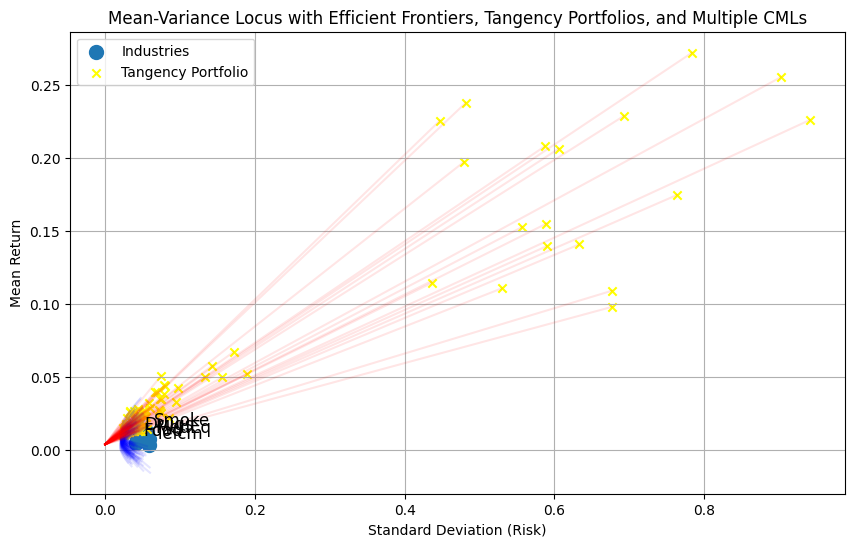

In [42]:
# Store efficient frontiers and tangency portfolios
rf=0.004
efficient_frontiers = []
tangency_points = []
tangency_table = []

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds for weights (between 0 and 1 for long-only portfolios)
    bounds = [(-10, 10)] * num_industries
    
    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers.append((frontier_returns, frontier_risks))

    # Compute Tangency Portfolio (Max Sharpe Ratio)
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - rf) / portfolio_volatility  # Negative Sharpe to minimize

    result = minimize(negative_sharpe_ratio, initial_guess, bounds=bounds, constraints=constraints)
    
    if result.success:
        weights = result.x
        tangency_return = np.sum(weights * mean_returns)
        tangency_risk = np.sqrt(weights.T @ cov_matrix @ weights)
        sharpe_ratio = (tangency_return - rf) / tangency_risk
        tangency_points.append((tangency_risk, tangency_return))
        tangency_table.append([i + 1] + list(weights) + [tangency_return, tangency_risk, sharpe_ratio])
    else:
        tangency_points.append((np.nan, np.nan))  # Handle failures

# Convert tangency points to arrays
tangency_points = np.array(tangency_points)

# Create DataFrame for Tangency Portfolio Table
columns = ["Iteration"] + selected_industries + ["Mean Return", "Standard Deviation", "Sharpe Ratio"]
tangency_df = pd.DataFrame(tangency_table, columns=columns)

# Plot mean-variance locus, efficient frontiers, tangency portfolios, and individual CMLs
plt.figure(figsize=(10, 6))
plt.scatter(expected_risks, expected_returns, marker='o', s=100, label="Industries")

# Plot efficient frontiers for each bootstrap subset iteration
for frontier_returns, frontier_risks in efficient_frontiers:
    plt.plot(frontier_risks, frontier_returns, alpha=0.1, color='blue')

# Plot CMLs for each bootstrap iteration
for i in range(n_samples):
    if not np.isnan(tangency_points[i, 0]):  # Ensure valid tangency portfolio
        cml_risks = np.linspace(0, tangency_points[i, 0], 50)
        cml_returns = rf + (tangency_points[i, 1] - rf) / tangency_points[i, 0] * cml_risks
        plt.plot(cml_risks, cml_returns, color='red', alpha=0.1)

# Plot Tangency Portfolios
plt.scatter(tangency_points[:, 0], tangency_points[:, 1], marker='x', color='yellow', label="Tangency Portfolio")

# Annotate each industry
for industry in selected_industries:
    plt.annotate(industry, (expected_risks[industry], expected_returns[industry]), fontsize=12, xytext=(5,5), textcoords='offset points')

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers, Tangency Portfolios, and Multiple CMLs")
plt.legend()
plt.grid(True)
plt.show()


In [43]:

print(tangency_df)
print("Mean Sharpe Ratio: ",tangency_df["Sharpe Ratio"].mean())

    Iteration       Food     Smoke     MedEq      Drugs     Telcm  \
0           1   0.236000 -0.002650 -0.019059   0.307000  0.478709   
1           2   0.420621  0.570481  0.416553   0.677818 -1.085473   
2           3   0.101996  0.310102  0.336398   0.219057  0.032447   
3           4  -0.425156  1.102906 -0.800325   0.855206  0.267368   
4           5  -0.053975  0.237788  0.567806   0.280455 -0.032074   
..        ...        ...       ...       ...        ...       ...   
95         96   0.115716  0.146474  0.273830   0.477035 -0.013055   
96         97   1.311000 -1.972095 -3.177014  10.000000 -5.161892   
97         98 -10.000000  0.028897  5.737140   7.835609 -2.601645   
98         99   0.145268  0.285944  0.503695   0.099041 -0.033948   
99        100   0.301024  0.762418 -0.125685   0.247485 -0.185243   

    Mean Return  Standard Deviation  Sharpe Ratio  
0      0.016168            0.027135      0.448425  
1      0.044013            0.079237      0.504976  
2      0.013321

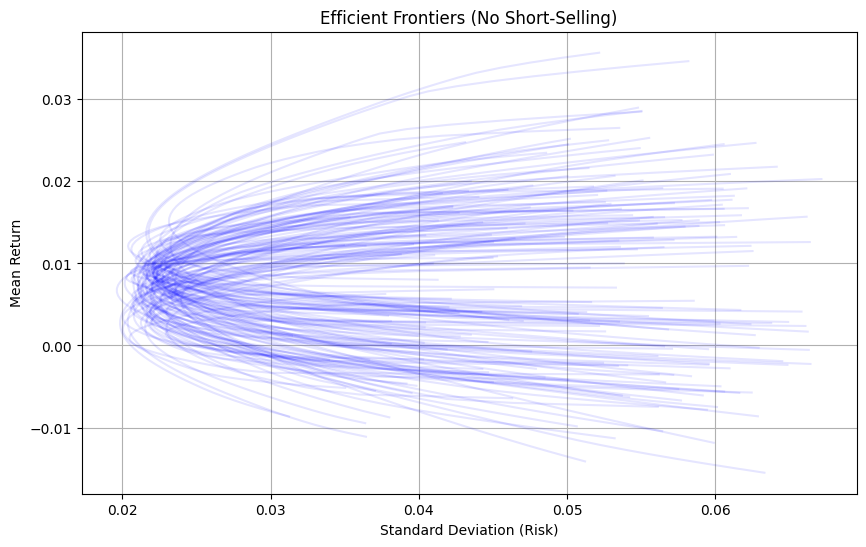

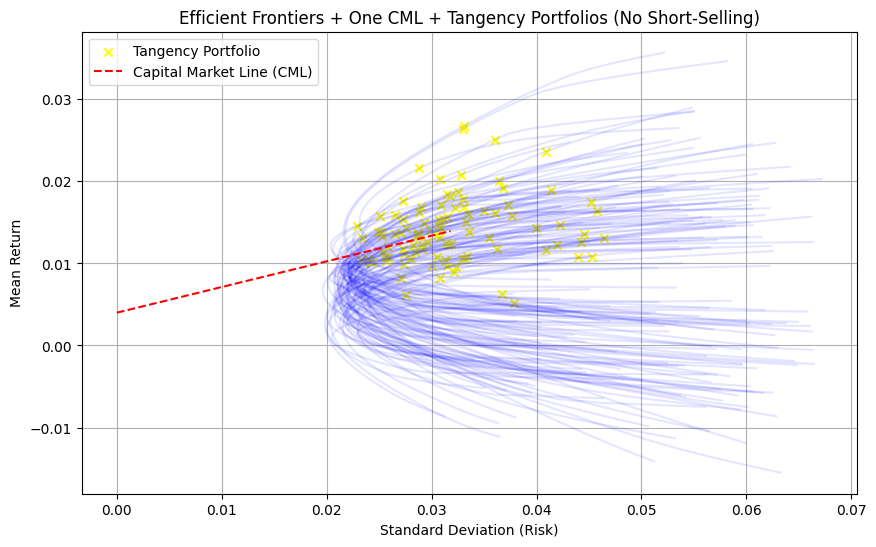

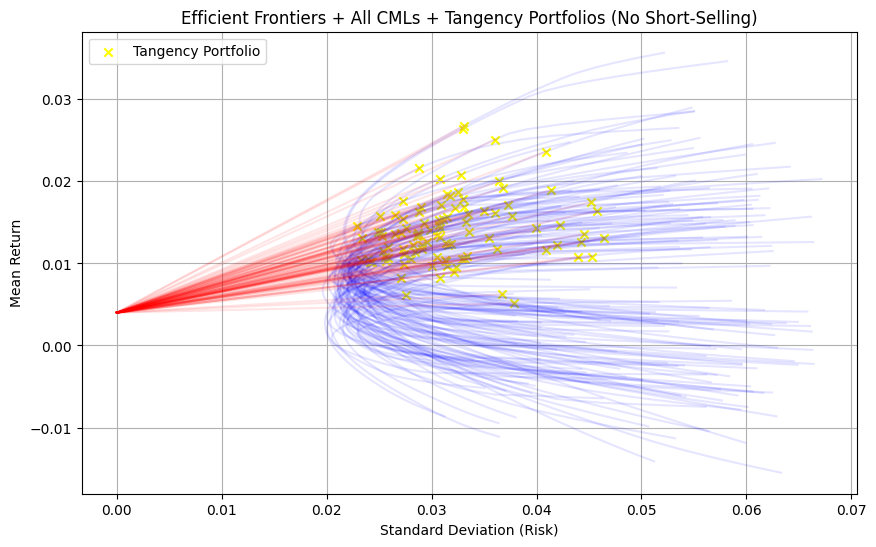

In [44]:
# Store efficient frontiers and tangency portfolios for no short-selling case
efficient_frontiers_no_short = []
tangency_points_no_short = []
tangency_table_no_short = []

# Set non-negative weights constraint (no short-selling)
bounds_no_short = [(0, 1)] * num_industries  # Weights must be between 0 and 1

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1 (fully invested portfolio)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation (no short-selling)
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds_no_short, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers_no_short.append((frontier_returns, frontier_risks))

    # Compute Tangency Portfolio (Max Sharpe Ratio, no short-selling)
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - rf) / portfolio_volatility  # Negative Sharpe to minimize

    result = minimize(negative_sharpe_ratio, initial_guess, bounds=bounds_no_short, constraints=constraints)
    
    if result.success:
        weights = result.x
        tangency_return = np.sum(weights * mean_returns)
        tangency_risk = np.sqrt(weights.T @ cov_matrix @ weights)
        sharpe_ratio = (tangency_return - rf) / tangency_risk
        tangency_points_no_short.append((tangency_risk, tangency_return))
        tangency_table_no_short.append([i + 1] + list(weights) + [tangency_return, tangency_risk, sharpe_ratio])
    else:
        tangency_points_no_short.append((np.nan, np.nan))  # Handle failures

# Convert tangency points to arrays
tangency_points_no_short = np.array(tangency_points_no_short)

# ----- Graph 1: Efficient Frontiers Only -----
plt.figure(figsize=(10, 6))
for frontier_returns, frontier_risks in efficient_frontiers_no_short:
    plt.plot(frontier_risks, frontier_returns, alpha=0.1, color='blue')
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Efficient Frontiers (No Short-Selling)")
plt.grid(True)
plt.show()

# ----- Graph 2: Add One CML + Tangency Portfolios -----
plt.figure(figsize=(10, 6))
for frontier_returns, frontier_risks in efficient_frontiers_no_short:
    plt.plot(frontier_risks, frontier_returns, alpha=0.1, color='blue')
plt.scatter(tangency_points_no_short[:, 0], tangency_points_no_short[:, 1], marker='x', color='yellow', label="Tangency Portfolio")
cml_risks = np.linspace(0, np.nanmean(tangency_points_no_short[:, 0]), 100)
cml_returns = rf + (np.nanmean(tangency_points_no_short[:, 1]) - rf) / np.nanmean(tangency_points_no_short[:, 0]) * cml_risks
plt.plot(cml_risks, cml_returns, color='red', linestyle="--", label="Capital Market Line (CML)")
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Efficient Frontiers + One CML + Tangency Portfolios (No Short-Selling)")
plt.legend()
plt.grid(True)
plt.show()

# ----- Graph 3: Add All CMLs + Tangency Portfolios -----
plt.figure(figsize=(10, 6))
for frontier_returns, frontier_risks in efficient_frontiers_no_short:
    plt.plot(frontier_risks, frontier_returns, alpha=0.1, color='blue')
for i in range(n_samples):
    if not np.isnan(tangency_points_no_short[i, 0]):  # Ensure valid tangency portfolio
        cml_risks = np.linspace(0, tangency_points_no_short[i, 0], 50)
        cml_returns = rf + (tangency_points_no_short[i, 1] - rf) / tangency_points_no_short[i, 0] * cml_risks
        plt.plot(cml_risks, cml_returns, color='red', alpha=0.1)
plt.scatter(tangency_points_no_short[:, 0], tangency_points_no_short[:, 1], marker='x', color='yellow', label="Tangency Portfolio")
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Efficient Frontiers + All CMLs + Tangency Portfolios (No Short-Selling)")
plt.legend()
plt.grid(True)
plt.show()

# ----- Table: Tangency Portfolio Details -----
columns = ["Iteration"] + selected_industries + ["Mean Return", "Standard Deviation", "Sharpe Ratio"]
tangency_df_no_short = pd.DataFrame(tangency_table_no_short, columns=columns)

In [45]:
print(tangency_df_no_short)
print("Mean Sharpe Ratio: ",tangency_df_no_short["Sharpe Ratio"].mean())

    Iteration          Food         Smoke         MedEq     Drugs  \
0           1  2.308485e-01  1.843144e-17  0.000000e+00  0.300527   
1           2  2.018713e-01  2.738536e-01  1.999206e-01  0.324354   
2           3  1.017578e-01  3.099122e-01  3.362397e-01  0.219043   
3           4  3.975934e-18  4.967325e-01  0.000000e+00  0.383534   
4           5  1.817329e-18  2.190200e-01  5.234031e-01  0.257577   
..        ...           ...           ...           ...       ...   
95         96  1.151289e-01  1.436436e-01  2.704445e-01  0.470783   
96         97  3.722840e-02  1.422473e-16  2.732189e-17  0.962772   
97         98  5.515668e-17  0.000000e+00  5.363496e-01  0.463650   
98         99  1.399501e-01  2.767492e-01  4.875727e-01  0.095728   
99        100  2.298027e-01  5.817553e-01  1.843144e-17  0.188442   

           Telcm  Mean Return  Standard Deviation  Sharpe Ratio  
0   4.686248e-01     0.015887            0.026534      0.447975  
1   0.000000e+00     0.013753          